# Viscoelastic wave propagator with Maxwell - GSLS formulation #

This tutorial was prepared by Paula Neves de Araujo (paulan@ime.usp.br).

This tutorial is an introduction to the isotropic viscoelastic wave propagator of Spyro using the Maxwell - GSLS formulation. The tutorial is an adaptation of the elastic forward notebook and is similar to the tutorial for the viscoelastic Kelvin-Voigt model.

First, the notebook environment is configured and the required modules are imported. If you are running this notebook in Google colab, please copy the following code into a code block before running the notebook:

```python
# For use in colab only:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

!pip install git+https://github.com/NDF-Poli-USP/spyro.git

In [3]:
%matplotlib inline
import spyro
import numpy as np

from firedrake import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [4]:
dictionary = {
    "options": {
        "cell_type": "Q",
        "variant": "lumped",
        "degree": 4,
        "dimension": 2,
    },
    "parallelism": {
        "type": "automatic",
    },
    "mesh": {
        "Lz": 1.0,
        "Lx": 1.0,
        "mesh_file": None,
        "mesh_type": "firedrake_mesh",
    },
    "acquisition": {
        "source_type": "ricker",
        "source_locations": [(-0.5, 0.5)],
        "frequency": 5.0,
        "delay": 0.2,
        "delay_type": "time",
        "receiver_locations": spyro.create_transect((-1.9, 1.2), (-1.9, 1.8), 300),
    },
    "time_axis": {
        "initial_time": 0.0,
        "final_time": 0.5,
        "dt": 0.0005,
        "output_frequency": 100,
        "gradient_sampling_frequency": 1,
    },
    "visualization": {
        "forward_output": True,
        "forward_output_filename": "results/forward_output.pvd",
        "fwi_velocity_model_output": False,
        "velocity_model_filename": None,
        "gradient_output": False,
        "gradient_filename": "results/Gradient.pvd",
        "adjoint_output": False,
        "adjoint_filename": None,
        "debug_output": False,
    },
    "viscoelasticity": {
        "viscoelastic": True,
        "visco_type": 'maxwell_gsls',
        "tau_sigma": 0.2,
        "tau_epsilon": 0.04,
# Tempos de relaxação associados a cada ramo
        "tau_epsilon_gsls" : [0.01, 0.1, 1.0],  # s
        "tau_sigma_gsls" : [0.02, 0.2, 2.0],  # s
        "lmbda_s" : [0.01, 0.05, 0.02],  # Pa
        "mu_s"    : [0.05, 0.02, 0.01],
    },
}

dictionary["synthetic_data"] = {
    "type": "object",
    "density": 0.1,
    "p_wave_velocity": 1.5,
    "s_wave_velocity": 1.0,
    "real_velocity_file": None,
}

dictionary["acquisition"]["amplitude"] = np.array([0, 1])


Note that "viscoelastic" is set to **True**. If this parameter is set to **False**, the elastic wave propagation is performed. We also have the "visco_type" parameter which is used to define the model to be adopted. In this notebook, we address the Generalized Maxwell formulation.

The **Generalized model of Maxwell** is a viscoelastic model that extends the classical Maxwell model by incorporating multiple **relaxation mechanisms**. It represents the material behavior as a purely elastic spring in parallel with several **Maxwell elements**, each consisting of a spring and a dashpot in series.

![Generalized model of Maxwell](generalized_maxwell_diagram.png)

This structure allows the GSLS model to reproduce a wide range of **attenuation** and **dispersion** behaviors by fitting observed frequency-dependent quality factors $Q(f)$ more accurately than simpler models.

In the time domain, the constitutive relation can be expressed as:

$$
\sigma + \sum_{n=1}^{N} \tau_{\sigma,n} \, \dot{\sigma}_n =
\lambda \, \text{tr}(\varepsilon) \, I + 2\mu \, \varepsilon +
\sum_{n=1}^{N} \tau_{\varepsilon,n} \left(
\lambda \, \text{tr}(\dot{\varepsilon}_n) \, I + 2\mu \, \dot{\varepsilon}_n
\right)
$$

or equivalently, as a sum over $ N $ Maxwell branches:

$$
\sigma = \sigma_e + \sum_{n=1}^{N} \sigma_n, \quad
\dot{\sigma}_n + \frac{1}{\tau_{\sigma,n}} \sigma_n =
\frac{1}{\tau_{\varepsilon,n}} \, C : \varepsilon
$$

where:

- $\sigma$ is the total stress tensor  
- $\varepsilon$ is the strain tensor  
- $\sigma_n$ and $\varepsilon_n$ are the stress and strain contributions of the $n$-th Maxwell element  
- $C$ is the elastic stiffness tensor  
- $\lambda, \mu$ are Lamé parameters  
- $\tau_{\sigma,n}$ and $\tau_{\varepsilon,n}$ are the relaxation and retardation times for the $n$-th mechanism  
- $I$ is the identity tensor  
- $\text{tr}(\cdot)$ denotes the trace operator  

The **GSLS-Maxwell** formulation provides a flexible framework to approximate **nearly constant-Q** behavior over a broad frequency range, making it particularly suitable for **seismic wave propagation** and **anelastic attenuation** modeling in geophysical simulations.


In the following, we build the "wave" object, which is an instance of "wave" type, and also stablish a periodic mesh for the example:

In [5]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Finally, the wave propagation can be performed:

In [6]:
wave.forward_solve()

Viscoelastic Maxwell/GSLS
Saving Displacement in: results/forward_outputsn0.pvd


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


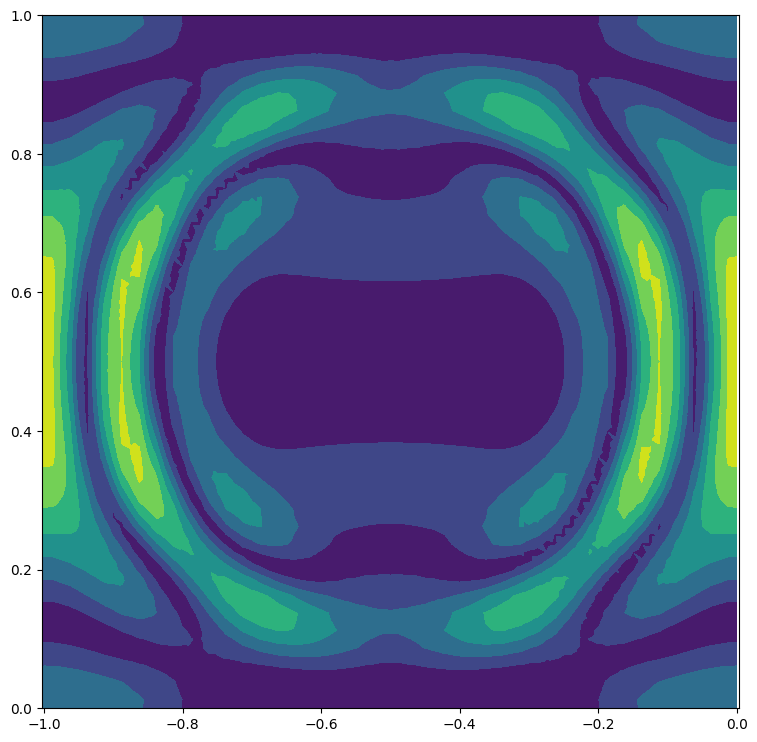

In [7]:
spyro.plots.plot_function(wave.u_n)